In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

# Load data

In [2]:
years = [i for i in range(1990, 2020)]
data_dir = "data_kaggle"
dfs1 = []
dfs2 = []
for y in tqdm(years):
    dfs1.append(pd.read_csv(f"{data_dir}/horses_{y}.csv"))
    dfs2.append(pd.read_csv(f"{data_dir}/races_{y}.csv"))

df1 = pd.concat(dfs1, axis=0)
df2 = pd.concat(dfs2, axis=0)

df = pd.merge(df1, df2, on="rid", how="left")
df["rid"].nunique()

 77%|███████▋  | 23/30 [00:17<00:05,  1.17it/s]/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/2260656286.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs1.append(pd.read_csv(f"{data_dir}/horses_{y}.csv"))
100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


380468

In [ ]:
# df = pd.read_csv("df.csv")

/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_92743/1162187833.py:1: DtypeWarning: Columns (11,37,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df.csv")


# Preprocess data

Fill age NaNs with median age. Label horses with horse_id (name_birthyear) to avoid confusing horses that share name

In [3]:
from datetime import datetime

median_age = np.median(df["age"])

df["age"] = df["age"].fillna(median_age)


df["date"] = pd.to_datetime(df["date"], yearfirst=True)
df["year"] = df["date"].dt.year
df["birth_year"] = df["year"] - df["age"]
df["horse_id"] = df["horseName"] + "_" + df["birth_year"].astype(str)
df["normalized_position"] = (df["position"] - 1) / (df["runners"] - 1)



/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/4119780022.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], yearfirst=True)


Deal with hurdle/fence column by adding columns for number of hurdles/fences

In [4]:
def add_hurdle_and_fence_counts(df):
    def extract_counts(value):
        if pd.isna(value):
            return pd.Series([0, 0])
        value = value.lower()
        hurdle_count = 0
        fence_count = 0
        if "hurdles" in value:
            hurdle_count = int(value.split("hurdles")[0].strip())
        elif "fences" in value:
            fence_count = int(value.split("fences")[0].strip())
        return pd.Series([hurdle_count, fence_count])
    
    df[["hurdle_count", "fence_count"]] = df["hurdles"].apply(extract_counts)
    return df


df = add_hurdle_and_fence_counts(df)


Deal with horse weight data

In [5]:
df["weight_total_lb"] = df["weightSt"] * 14 + df["weightLb"]
df["overWeight"] = pd.to_numeric(df["overWeight"], errors="coerce").fillna(0)
df["weight_with_over"] = df["weight_total_lb"] + df["overWeight"]
df["is_overweight"] = df["overWeight"] > 0

df["race_avg_weight"] = df.groupby("rid")["weight_with_over"].transform("mean")
df["weight_diff_from_race_avg"] = df["weight_with_over"] - df["race_avg_weight"]


Estimate finish times from positions using lengths->seconds conversion


In [6]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

# Filter out rows where winningTime = 0
df = df.loc[df["winningTime"] != 0]

conversion = {
    "nse": 0.05,
    "shd": 0.1,
    "hd": 0.2,
    "nk": 0.3
}

df["positionL_clean"] = pd.to_numeric(df["positionL"], errors="coerce")
df["positionL_clean"] = df["positionL_clean"].fillna(df["positionL"].map(conversion)).fillna(0)
# Sort by race and position
df = df.sort_values(by=["rid", "position"])

# For each race, compute cumulative margin
df["margin_from_winner"] = df.groupby("rid")["positionL_clean"].cumsum()


def clean_and_estimate_finish_times(df, winning_time_col="winningTime"):
    # """
    # Estimates finish time.
    # """

    # Estimate finish time: base + margin * conversion factor
    # Using 0.25 seconds per length for jumps
    SECONDS_PER_LENGTH = 0.25
    df["estimated_time_behind_leader"] = df["margin_from_winner"] * SECONDS_PER_LENGTH
    df["estimated_finish_time"] = df[winning_time_col] + df["estimated_time_behind_leader"]

    return df

df = clean_and_estimate_finish_times(df)

Convert distance column to be in furlongs only

In [7]:
def convert_distance_to_furlongs(df, col="distance"):
    """
    Converts a distance string like '2m', '1m6f', '2m1½f' into a float number of furlongs.
    1 mile = 8 furlongs, so '1m6f' = 14 furlongs.
    """
    import re

    def parse_distance(value):
        if pd.isna(value):
            return np.nan

        # Extract miles and furlongs (including fractional furlongs)
        miles = 0
        furlongs = 0.0

        # Match miles and furlongs
        mile_match = re.search(r"(\d+)m", value)
        if mile_match:
            miles = int(mile_match.group(1))

        # Match furlongs including fractions (e.g., ½)
        furlong_match = re.search(r"(\d+)?(?:½)?f", value)
        if furlong_match:
            f_str = furlong_match.group(1)
            if f_str:
                furlongs += int(f_str)
            if "½f" in value:
                furlongs += 0.5

        return miles * 8 + furlongs

    df["distance_furlongs"] = df[col].apply(parse_distance)
    return df

df = convert_distance_to_furlongs(df)

Convert estimated finishing times to percent difference from the average finish time for given race distance. Remove outliers.

In [8]:
def calculate_diff_from_distance_median(df):
    """
    Calculates average finish time for each race, then represents each horse's finish time as a percentage difference form the expected
    """

    df["distance_median_finish_time"] = df.groupby("distance_furlongs")["estimated_finish_time"].transform("median")
    # # Compute rolling mean of estimated_finish_time by distance (only past races)
    # # Step 1: One row per race
    # race_means = (
    #     df.groupby("rid").agg({
    #         "date": "first",
    #         "distance_furlongs": "first",
    #         "estimated_finish_time": "mean"
    #     }).reset_index()
    # )

    # # Step 2: Sort by date, compute rolling mean per distance (only prior races)
    # race_means = race_means.sort_values("date")

    # # Add rolling average of prior races per distance
    # race_means["distance_median_finish_time"] = (
    #     race_means
    #     .groupby("distance_furlongs")["estimated_finish_time"]
    #     .transform(lambda x: x.shift().expanding().mean())
    # )

    # # Step 3: Merge back to full df (on race ID)
    # df = df.merge(
    #     race_means[["rid", "distance_median_finish_time"]],
    #     on="rid",
    #     how="left"
    # )

    df["time_performance"] = (df["estimated_finish_time"] - df["distance_median_finish_time"])/df["distance_median_finish_time"]

    return df

df = calculate_diff_from_distance_median(df)

# Remove time_performance outliers

# thresh = 0.3
# df = df.loc[df["time_performance"].abs() < thresh]


Remove any race containing suspciously extreme performance

In [9]:
def remove_time_performance_outlier_races(df, thresh=0.2):

    df2 = df[["rid", "time_performance"]].copy()

    thresh = 0.2
    mask = df2["time_performance"].abs() > thresh

    df2 = df2.loc[mask, "rid"].drop_duplicates()


    df = df.loc[~(df["rid"].isin(df2))]

    return df

df = remove_time_performance_outlier_races(df)


(3866110, 62)

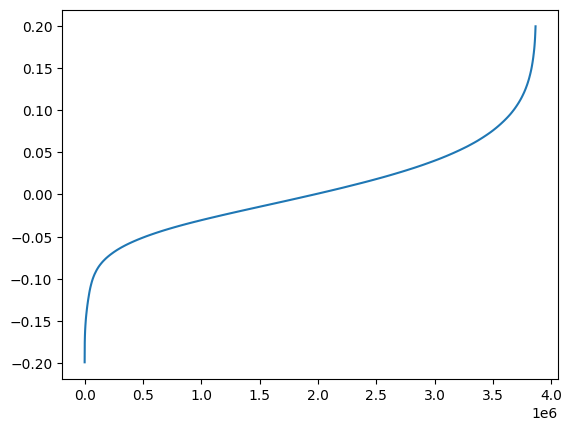

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import zscore


# plt.plot(df.loc[mask, "time_performance"].sort_values().values)
plt.plot(df["time_performance"].sort_values().values)

# print(df.shape, df.loc[df["time_performance"].abs() <= thresh].shape, df.loc[df["time_performance"].abs() <= thresh].shape[0]/df.shape[0])
# print(df.shape, df.loc[mask, "time_performance"].shape, df.loc[mask, "time_performance"].shape[0]/df.shape[0])


df.shape

## Horse and jockey finish time trends

In [10]:
import numpy as np


df["horse_form_avg_3"] = (
    df.groupby("horse_id")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
)
def form_trend(x):
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    t = np.arange(len(x))
    slope = np.polyfit(t, x.values, 1)[0]
    return slope

df["horse_form_trend_3"] = (
    df.groupby("horse_id")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(3, min_periods=2).apply(form_trend, raw=False))
)

df["horse_form_volatility_3"] = (
    df.groupby("horse_id")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(3, min_periods=1).std())
)

df["horse_win_rate_5"] = (
    df.groupby("horse_id")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).apply(lambda s: (s == 0).mean()))
)

def weighted_momentum(x):
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    weights = np.exp(-0.5 * np.arange(len(x))[::-1])  # more recent = higher weight
    return np.average(x, weights=weights)

df["horse_form_momentum"] = (
    df.groupby("horse_id")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).apply(weighted_momentum, raw=False))
)

df = df.sort_values(by=["jockeyName", "date"])

df["jockey_form_avg_3"] = (
    df.groupby("jockeyName")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
)

df["jockey_form_trend_3"] = (
    df.groupby("jockeyName")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(3, min_periods=2).apply(form_trend, raw=False))
)

df["jockey_form_volatility_3"] = (
    df.groupby("jockeyName")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(3, min_periods=1).std())
)

df["jockey_win_rate_5"] = (
    df.groupby("jockeyName")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).apply(lambda s: (s == 0).mean()))
)

df["jockey_form_momentum"] = (
    df.groupby("jockeyName")["time_performance"]
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).apply(weighted_momentum, raw=False))
)




Horse parents data

In [11]:
df.loc[(df['father'].isin(df["horseName"]) & df['mother'].isin(df["horseName"]))].shape[0]

df_life_results = df[["horseName", "time_performance"]].copy()

df_life_results["lifetime_mean_performance"] = df_life_results.groupby("horseName")["time_performance"].transform("mean")

df_life_results = df_life_results[["horseName", "lifetime_mean_performance"]].drop_duplicates()

df_life_results.rename(columns={
    "horseName":"father",
    "lifetime_mean_performance": "lifetime_mean_performance_father"
}, inplace=True)

df = pd.merge(df, df_life_results, on="father", how="left")

df_life_results.rename(columns={
    "father":"gfather",
    "lifetime_mean_performance_father": "lifetime_mean_performance_gfather"
}, inplace=True)

df = pd.merge(df, df_life_results, on="gfather", how="left")

df_life_results.rename(columns={
    "gfather":"mother",
    "lifetime_mean_performance_gfather": "lifetime_mean_performance_mother"
}, inplace=True)

df = pd.merge(df, df_life_results, on="mother", how="left")


df



,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,horse_win_rate_5,horse_form_momentum,jockey_form_avg_3,jockey_form_trend_3,jockey_form_volatility_3,jockey_win_rate_5,jockey_form_momentum,lifetime_mean_performance_father,lifetime_mean_performance_gfather,lifetime_mean_performance_mother
0,339986,Touching Down,10.0,13.0,0.014925,0,P York,2Lt Claire Llewellin,12,13,...,0.0,-0.006344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,241606,Majestic Bruno,6.0,0.0,0.047619,0,N A Gaselee,A Adams,3,30,...,0.0,0.028761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,244461,Hope Cove,7.0,0.0,0.076923,0,N A Gaselee,A Adams,4,15,...,0.0,0.034462,0.020344,NaN,NaN,0.0,0.020344,NaN,NaN,NaN
3,350105,Lesbet,5.0,0.0,0.266667,0,C P Wildman,A Adams,1,NaN,...,0.0,-0.028352,0.001435,-0.037817,0.026740,0.0,-0.003196,NaN,NaN,NaN
4,321328,Mr Entertainer,7.0,0.0,0.038462,0,N A Gaselee,A Adams,5,4,...,0.0,-0.000807,-0.036814,-0.066829,0.068896,0.0,-0.058968,NaN,0.012198,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866105,306806,Red Lord,4.0,NaN,0.006623,0,Anthony Cummings,NaN,9,1.5,...,0.0,-0.071915,NaN,NaN,NaN,NaN,NaN,-0.025310,NaN,NaN
3866106,199740,Kokouchu,4.0,14.0,0.019608,0,M Boutin,NaN,40,NaN,...,0.0,0.000990,NaN,NaN,NaN,NaN,NaN,-0.035230,NaN,NaN
3866107,45964,Gullit,5.0,14.0,0.033333,0,Julio Gularte,NaN,13,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3866108,291393,Winter Magic,3.0,NaN,0.002404,0,Hiroshi Sasano,NaN,14,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010731,0.019499


Save pre-processed data

In [12]:
df.to_csv("df.csv")

Load pre-processed data

In [3]:
import pandas as pd
df = pd.read_csv("df.csv")

/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_8181/1687336823.py:2: DtypeWarning: Columns (11,37,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df.csv")


# Train/test split

In [13]:

X_cols = [
    "horse_id", # Encode
    "condition", # Encode
    "distance_furlongs", # Scale
    "hurdle_count", # Scale
    "fence_count", # Scale
    "ages", # Encode
    "band", # Encode
    "rclass", # Encode
    "OR", # Scale
    "headGear", # Encode
    "weight_total_lb", # Scale
    "weight_diff_from_race_avg", # Scale
    "isFav", # Unchanged
    # "decimalPrice", # Scale
    "saddle", # Encode
    "age", # Scale
    "horse_form_avg_3", # Scale...
    "horse_form_trend_3", #
    "horse_form_volatility_3", #
    "horse_win_rate_5", #
    "horse_form_momentum",#
    "jockey_form_avg_3",#
    "jockey_form_trend_3",#
    "jockey_form_volatility_3",#
    "jockey_win_rate_5",#
    "jockey_form_momentum",# ...Scale
    "lifetime_mean_performance_father",
    "lifetime_mean_performance_mother",
    "lifetime_mean_performance_gfather"
]

y_col = "time_performance"

val_cols = X_cols + [y_col] + ["position", "res_win", "res_place", "rid", "decimalPrice"]
df = df.dropna(subset=[y_col])



In [5]:
df

,Unnamed: 0,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,...,horse_form_avg_3,horse_form_trend_3,horse_form_volatility_3,horse_win_rate_5,horse_form_momentum,jockey_form_avg_3,jockey_form_trend_3,jockey_form_volatility_3,jockey_win_rate_5,jockey_form_momentum
0,3335061,339986,Touching Down,10.0,13.0,0.014925,0,P York,2Lt Claire Llewellin,12,...,-0.012435,0.026204,0.026289,0.0,-0.007328,NaN,NaN,NaN,NaN,NaN
1,2360518,241606,Majestic Bruno,6.0,0.0,0.047619,0,N A Gaselee,A Adams,3,...,0.025853,0.024069,0.024138,0.0,0.033876,NaN,NaN,NaN,NaN,NaN
2,2389213,244461,Hope Cove,7.0,0.0,0.076923,0,N A Gaselee,A Adams,4,...,0.035834,-0.105330,0.074480,0.0,0.022936,-0.008988,NaN,NaN,0.0,-0.008988
3,3435640,350105,Lesbet,5.0,0.0,0.266667,0,C P Wildman,A Adams,1,...,-0.033450,-0.034239,0.075352,0.0,-0.030012,0.016682,0.051340,0.036303,0.0,0.022969
4,3150252,321328,Mr Entertainer,7.0,0.0,0.038462,0,N A Gaselee,A Adams,5,...,0.001075,0.007054,0.022401,0.0,0.004149,-0.013570,-0.032543,0.058348,0.0,-0.026181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943441,3006687,306806,Red Lord,4.0,NaN,0.006623,0,Anthony Cummings,NaN,9,...,-0.099782,0.055858,0.063104,0.0,-0.081231,NaN,NaN,NaN,NaN,NaN
3943442,1945033,199740,Kokouchu,4.0,14.0,0.019608,0,M Boutin,NaN,40,...,-0.017540,-0.003962,0.004467,0.0,-0.018715,NaN,NaN,NaN,NaN,NaN
3943443,453328,45964,Gullit,5.0,14.0,0.033333,0,Julio Gularte,NaN,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3943444,2853919,291393,Winter Magic,3.0,NaN,0.002404,0,Hiroshi Sasano,NaN,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# df.loc[df["rid"] == 27934].sort_values("position").to_csv("test1.csv")

# print(df.loc[df["time_performance"] < -0.15].shape[0]/df.shape[0])
# print(df.loc[df["time_performance"] > 0.15].shape[0]/df.shape[0])
# print(df.shape)
cols = ["rid", "distance", "distance_furlongs", "horseName", "course", "date","position", "positionL_clean", "winningTime", "distance_median_finish_time", "estimated_finish_time", "time_performance"]
df.loc[df["time_performance"].abs() > 0.5, cols].to_csv("test1.csv")
df.loc[(df["distance_furlongs"] == 5) & (df["winningTime"]>100), cols].to_csv("test2.csv")


Index(['rid', 'horseName', 'age', 'saddle', 'decimalPrice', 'isFav',
       'trainerName', 'jockeyName', 'position', 'positionL', 'dist',
       'weightSt', 'weightLb', 'overWeight', 'outHandicap', 'headGear', 'RPR',
       'TR', 'OR', 'father', 'mother', 'gfather', 'runners', 'margin',
       'weight', 'res_win', 'res_place', 'course', 'time', 'date', 'title',
       'rclass', 'band', 'ages', 'distance', 'condition', 'hurdles', 'prizes',
       'winningTime', 'prize', 'metric', 'countryCode', 'ncond', 'class',
       'year', 'birth_year', 'horse_id', 'normalized_position', 'hurdle_count',
       'fence_count', 'weight_total_lb', 'weight_with_over', 'is_overweight',
       'race_avg_weight', 'weight_diff_from_avg', 'positionL_clean',
       'margin_from_winner', 'estimated_time_behind_leader',
       'estimated_finish_time', 'distance_furlongs',
       'distance_median_finish_time', 'time_performance', 'horse_form_avg_3',
       'horse_form_trend_3', 'horse_form_volatility_3', 'horse_w

In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# Change to scale/encode train data first

def prepare_training_data(df, X_cols, val_cols, y_col=y_col):

    # Select features and target
    X = df[X_cols]
    y = df[y_col]
    df_val = df[val_cols]

    # Split by race and time
    rids_sorted = df.sort_values("date")["rid"].drop_duplicates().values
    n = len(rids_sorted)

    # 70% train, 10% val, 20% test
    train_rids = rids_sorted[:int(0.7 * n)]
    val_rids   = rids_sorted[int(0.7 * n):int(0.8 * n)]
    test_rids  = rids_sorted[int(0.8 * n):]

    # Apply to X and y
    X_train = X[df["rid"].isin(train_rids)]
    y_train = y[df["rid"].isin(train_rids)]

    df_val = df_val[df["rid"].isin(val_rids)]

    X_test = X[df["rid"].isin(test_rids)]
    y_test = y[df["rid"].isin(test_rids)]

    # Separate features into types
    categorical_cols = [
        "condition", 
        "ages", 
        "band", 
        "rclass", 
        "headGear", 
        "saddle",
        "horse_id"
    ]
    scale_cols = [col for col in X_cols if col not in categorical_cols + ["isFav"]]

    # Fill missing values
    df = df.copy()
    df[categorical_cols] = df[categorical_cols].fillna("Unknown")
    df[scale_cols] = df[scale_cols].fillna(0)
    df["isFav"] = df["isFav"].fillna(0)

    # Encode categorical variables
    le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[categorical_cols] = le.fit_transform(X_train[categorical_cols].astype(str))
    X_test[categorical_cols] = le.transform(X_test[categorical_cols].astype(str))
    df_val[categorical_cols] = le.transform(df_val[categorical_cols].astype(str))


    # Scale numerical features
    scalers = {}
    for col in scale_cols:
        print(col)
        scaler = StandardScaler()
        X_train.loc[:,col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
        X_test.loc[:,col] = scaler.transform(X_test[col].values.reshape(-1,1))
        df_val.loc[:,col] = scaler.transform(df_val[col].values.reshape(-1,1))
        scalers[col] = scaler

    y_scaler = MinMaxScaler()

    y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))
    y_test = y_scaler.transform(y_test.values.reshape(-1,1))
    df_val[y_col] = y_scaler.transform(df_val[y_col].values.reshape(-1,1))

    scalers[y_col] = y_scaler


    # Return all sets
    return X_train, X_test, y_train, y_test, df_val, le, scalers



In [15]:
X_train, X_test, y_train, y_test, df_val, label_encoders, scalers = prepare_training_data(df, X_cols, val_cols)
X_train.columns



/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_cols] = le.fit_transform(X_train[categorical_cols].astype(str))
/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_cols] = le.transform(X_test[categorical_cols].astype(str))


distance_furlongs
hurdle_count


/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50485707 -0.50485707 -0.50485707 ... -0.50485707 -0.50485707
 -0.50485707]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:,col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50485707 -0.50485707 -0.50485707 ... -0.50485707 -0.50485707
 -0.50485707]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:,col] = scaler.transform(X_test[col].values.reshape(-1,1))
/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:63: FutureWarning: Setting an item o

fence_count
OR
weight_total_lb
weight_diff_from_race_avg


/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.54931041  0.99784321  0.69147255 ... -0.41146185 -1.26929971
 -0.35018771]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:,col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.22763945 -1.02420317 -0.84038078 ... -0.47273598 -0.90165491
  0.20127948]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:,col] = scaler.transform(X_test[col].values.reshape(-1,1))
/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/3258298931.py:63: FutureWarning: Setting an item o

age
horse_form_avg_3
horse_form_trend_3
horse_form_volatility_3
horse_win_rate_5
horse_form_momentum
jockey_form_avg_3
jockey_form_trend_3
jockey_form_volatility_3
jockey_win_rate_5
jockey_form_momentum
lifetime_mean_performance_father
lifetime_mean_performance_mother
lifetime_mean_performance_gfather


Index(['horse_id', 'condition', 'distance_furlongs', 'hurdle_count',
       'fence_count', 'ages', 'band', 'rclass', 'OR', 'headGear',
       'weight_total_lb', 'weight_diff_from_race_avg', 'isFav', 'saddle',
       'age', 'horse_form_avg_3', 'horse_form_trend_3',
       'horse_form_volatility_3', 'horse_win_rate_5', 'horse_form_momentum',
       'jockey_form_avg_3', 'jockey_form_trend_3', 'jockey_form_volatility_3',
       'jockey_win_rate_5', 'jockey_form_momentum',
       'lifetime_mean_performance_father', 'lifetime_mean_performance_mother',
       'lifetime_mean_performance_gfather'],
      dtype='object')

# Random Forest model

Train and predict

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

def train_predict_random_forest_regressor(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    metrics = {
        "RMSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R^2": r2_score(y_test, y_pred)
    }

    return model, y_pred, metrics




model, y_pred, metrics = train_predict_random_forest_regressor(X_train, y_train, X_test, y_test)

pd.DataFrame.from_dict({"y_test":list(y_test), "y_pred":list(y_pred)}).to_csv("rf_model/pred.csv")
joblib.dump(model, 'rf_model/model.pkl') 

print(metrics)



/Users/howm/Desktop/horseracing/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'RMSE': 0.008517529637831553, 'MAE': 0.07183046813595603, 'R^2': 0.47549750428362725}


Previous: {'RMSE': 0.004048952061265925, 'MAE': 0.0487379686674782, 'R^2': 0.4994516084103343}

Load model from file

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

model = joblib.load('rf_model/model.pkl')

def load_predict_random_forest_regressor(X_train, y_train, X_test, y_test):

    y_pred = model.predict(X_test)

    # Evaluate
    metrics = {
        "RMSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R^2": r2_score(y_test, y_pred)
    }

    return y_pred, metrics

y_pred, metrics = load_predict_random_forest_regressor(X_train, y_train, X_test, y_test)
pd.DataFrame.from_dict({"y_test":list(y_test), "y_pred":list(y_pred)}).to_csv("rf_model/pred.csv")
print(metrics)


{'RMSE': 0.008517529637831553, 'MAE': 0.07183046813595603, 'R^2': 0.47549750428362725}


In [18]:
import numpy as np

print(f"y_test Min: {y_test.min()}, Max: {y_test.max()}, Mean: {y_test.mean()}, Std: {y_test.std()}")
print(f"y_train Min: {y_train.min()}, Max: {y_train.max()}, Mean: {y_train.mean()}, Std: {y_train.std()}")



mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)




y_test Min: -0.001939644073489566, Max: 0.9998353471342777, Mean: 0.4837918439978038, Std: 0.12743333447897442
y_train Min: 0.0, Max: 1.0, Mean: 0.5162237579513839, Std: 0.13469673771228066


# Look into results and check no data leakage etc. Then run monte carlo to test whther results actually accurate to real life/would make money or whatever

In [19]:
y_train_is = scalers[y_col].inverse_transform(y_train.reshape(-1,1))
y_test_is = scalers[y_col].inverse_transform(y_test.reshape(-1,1))
y_pred_is = scalers[y_col].inverse_transform(y_pred.reshape(-1,1))

print(f"y_train Min: {y_train_is.min()}, Max: {y_train_is.max()}, Mean: {y_train_is.mean()}, Std: {y_train_is.std()}")
print(f"y_test Min: {y_test_is.min()}, Max: {y_test_is.max()}, Mean: {y_test_is.mean()}, Std: {y_test_is.std()}")
print(f"y_pred Min: {y_pred_is.min()}, Max: {y_pred_is.max()}, Mean: {y_pred_is.mean()}, Std: {y_pred_is.std()}")

mse = mean_squared_error(y_test_is, y_pred_is)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_is, y_pred_is)
r2 = r2_score(y_test_is, y_pred_is)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² score: {r2:.4f}")

y_train Min: -0.19857593327230183, Max: 0.1999841972187104, Mean: 0.007170275059362417, Std: 0.05368474935932022
y_test Min: -0.19934899806733797, Max: 0.1999185731510624, Mean: -0.005755792798049743, Std: 0.05078984641884487
y_pred Min: -0.1461321921753448, Max: 0.1737713821261187, Mean: 0.0019662272437864516, Std: 0.03594920994856652
MSE: 0.0014
RMSE: 0.0368
MAE: 0.0286
R² score: 0.4755


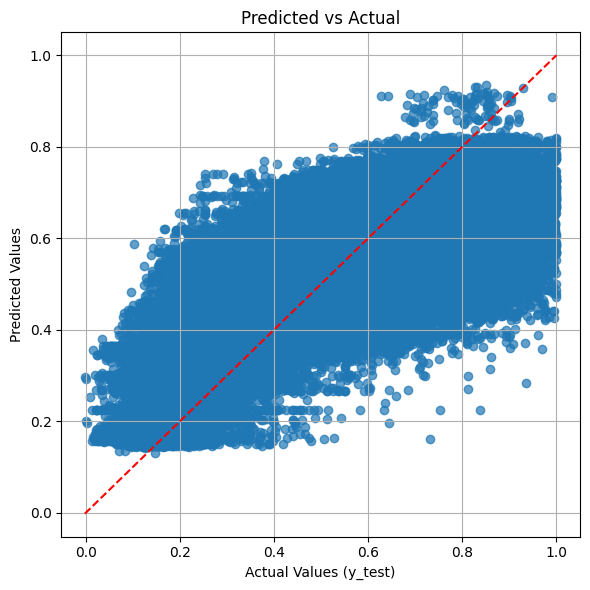

In [20]:
import matplotlib.pyplot as plt
import numpy as np


# --- Scatter plot: Predicted vs Actual ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.tight_layout()
plt.show()



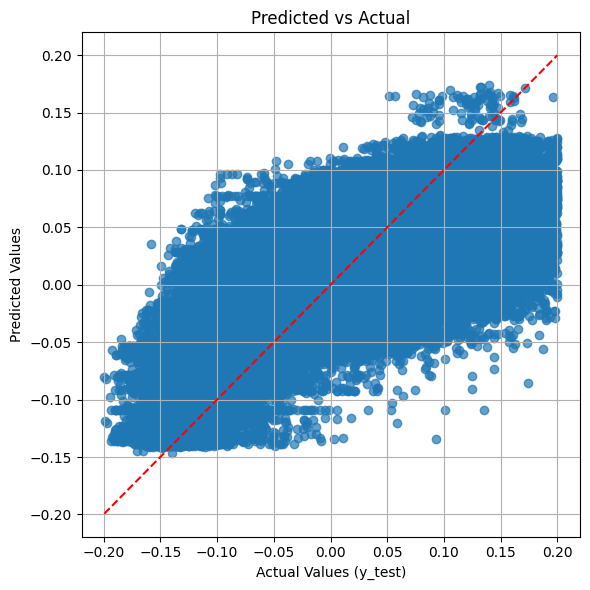

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# --- Scatter plot: Predicted vs Actual ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test_is, y_pred_is, alpha=0.7)
plt.plot([y_test_is.min(), y_test_is.max()], [y_test_is.min(), y_test_is.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.tight_layout()
plt.show()




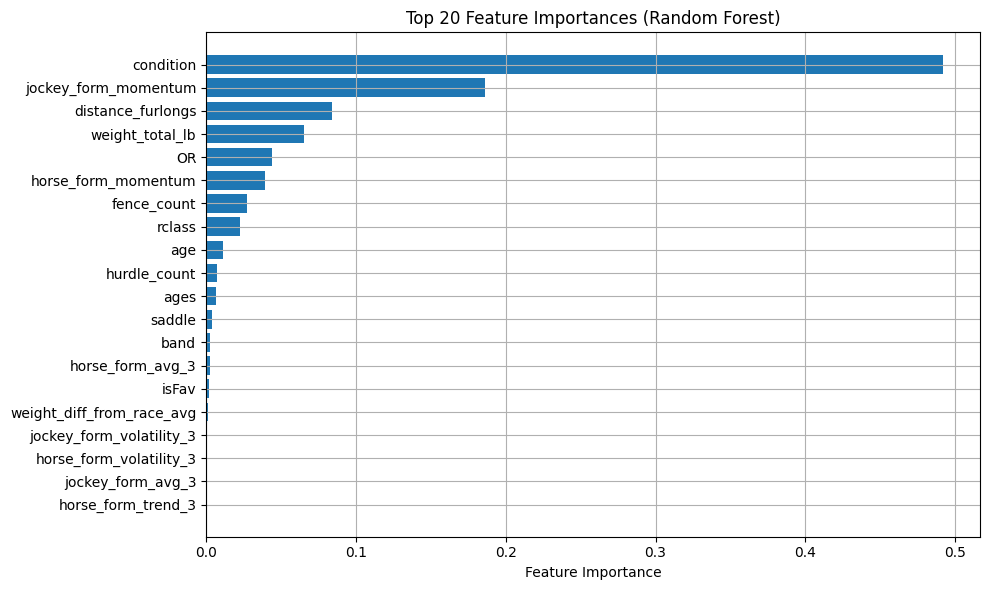

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importances(model, feature_names, top_n=20):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances

    }).sort_values(by="importance", ascending=False).head(top_n)


    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_feature_importances(model, X_train.columns)


# Monte Carlo simulation

In [37]:
import numpy as np
import pandas as pd
from collections import defaultdict
import sys

y_train_std = y_train.std()

def monte_carlo_race_simulation(model, X_val, df_val, n_simulations=1000, noise_std=y_train_std):
    # Make sure data is sorted
    df_val = df_val.copy()
    df_val["pred"] = model.predict(X_val)
    # print(df_val.columns)
    
    # Store results
    win_counts = defaultdict(int)

    # Group by race
    grouped = df_val.groupby("rid")

    total = df_val["rid"].nunique()

    for i in range(n_simulations):
        count=0
        for rid, race in grouped:
            sys.stdout.write(f"\rSim {i}: Processing {count}/{total}")
            sys.stdout.flush()
            horses = race.copy()
            # Add Gaussian noise to simulate uncertainty
            horses["sim_time"] = horses["pred"] + np.random.normal(0, noise_std, size=len(horses))
            # Pick the winner (lowest simulated time)
            winner_id = horses.loc[horses["sim_time"].idxmin(), "horse_id"]
            win_counts[winner_id] += 1
            count+=1


    # Convert to DataFrame
    sim_results = pd.DataFrame({
        "horse_id": list(win_counts.keys()),
        "simulated_wins": list(win_counts.values())
    })

    # Normalize to probabilities
    sim_results["simulated_win_probability"] = sim_results["simulated_wins"] / n_simulations

    return sim_results

X_val = df_val[X_cols]
# Assumes you have: model, X_val, df_val (validation set with rid + horse_id)
sim_results = monte_carlo_race_simulation(model, X_val, df_val, n_simulations=5, noise_std=y_train_std)

# To see the most likely winners:
sim_results.sort_values("simulated_win_probability", ascending=False).head()


Sim 4: Processing 37248/37249

,horse_id,simulated_wins,simulated_win_probability
0,-1.0,83396,16679.2
4872,185152.0,40,8.0
997,193486.0,37,7.4
2569,119447.0,37,7.4
2256,192995.0,35,7.0


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict

def race_sim_simple(model, X_val, df_val, n_simulations=1000, noise_std=0.3):
    # Make sure data is sorted
    df = df_val.copy()
    df["pred"] = model.predict(X_val)
    

    # Group by race
    df["position_pred"] = df.groupby("rid")["pred"].rank(method="first", ascending=True).astype(int)

    df["res_win_pred"] = 0
    df.loc[df["position_pred"] == 1, "res_win_pred"] = 1
    df["res_place_pred"] = 0
    df.loc[df["position_pred"] <= 3, "res_place_pred"] = 1


    df["odds"] = 1/df["decimalPrice"]

    stake_per_race = 1

    df["stake"] = 0
    df.loc[df["res_win_pred"] == 1, "stake"] = stake_per_race
    df["winnings"] = 0
    df.loc[(df["res_win"] == 1) & (df["res_win_pred"] == 1), "winnings"] = df["stake"] + (df["odds"]*df["stake"])

    total_staked = df["stake"].sum()
    total_races = df["rid"].nunique()
    total_winnings = round(df["winnings"].sum(),2)
    net = round(total_winnings - total_staked,2)
    races_won = df.loc[(df["res_win"] == 1) & (df["res_win_pred"] == 1)].shape[0]

    print(f"Total races: {total_races}. Total staked: {total_staked}. Total won: {total_winnings} over {races_won} races. Net: {net}. Profit: {round((net/total_staked)*100,2)}%")

    return df

X_val = df_val[X_cols]
# Assumes you have: model, X_val, df_val (validation set with rid + horse_id)
sim_results = race_sim_simple(model, X_val, df_val, n_simulations=1000, noise_std=0.3)

sim_results.loc[sim_results["winnings"] != 0].to_csv("sim_results.csv")


/var/folders/2v/qtt6l4nd0ydcbdvk1h4pjkzmbfzb8t/T/ipykernel_2141/58328662.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.33333333 3.         3.5        ... 8.         2.3        7.1       ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df["res_win"] == 1) & (df["res_win_pred"] == 1), "winnings"] = df["stake"] + (df["odds"]*df["stake"])


Total races: 37249. Total staked: 37249. Total won: 41490.66 over 7035 races. Net: 4241.66. Profit: 11.39%
